In [ ]:
%pip install git+https://github.com/patrolSU2019/bbrl_gym.git

In [4]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy
from bbrl_gym.envs.maze_mdp import MazeMDPEnv


# Settings
NB_EPISODES = 50
TIMEOUT = 25


import gym
import bbrl_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2})
env.reset()

# set this False to render correctly in pycharm
# env.mdp.plotter.using_notebook = False

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Matplotlib backend: module://matplotlib_inline.backend_inline


Output()

In [5]:
import collections


class ReplayBuffer:
    def __init__(self, max_size: int = 1000):
        self.max_size = max_size
        self.buffer = collections.deque(maxlen=max_size)

    def add(self, experience: Tuple):
        if len(self.buffer) >= self.max_size:
            self.buffer.popleft()
        self.buffer.append(experience)
    
    def size(self):
        return len(self.buffer)
    
    def sample(self, batch_size: int) -> Tuple:
        buffer_flat = np.array(self.buffer).reshape(-1, 6)  # convert buffer to 2D array
        indices = np.random.choice(len(buffer_flat), size=batch_size, replace=False)
        batch = buffer_flat[indices]
        states, actions, rewards, next_states,goals, dones = batch[:, 0], batch[:, 1], batch[:, 2], batch[:, 3], batch[:, 4], batch[:, 5].astype(bool)
        return states, actions, rewards, next_states, goals,dones

In [11]:
def q_learning_eps_her(
    mdp: MazeMDPEnv,
    epsilon: float = 0.01,
    nb_episodes: int = 500,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
    batch_size: int = 32,
    replay_buffer_size: int = 1000,
    her_k = 6,
) -> Tuple[np.ndarray, List[float], List[int]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.nb_states -1 ,mdp.action_space.n))
    q_list = []
    time_list = []
    
    replay_buffer = ReplayBuffer(max_size = replay_buffer_size)

    # Run learning cycle
    mdp.set_timeout(timeout)  # episode length

    

    if render:
        mdp.init_draw(f"Q-learning e-greedy with HER and goal")
    goal = np.random.randint(mdp.nb_states-1)
    mdp.change_last_states([goal])
    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = False
    
        trajectory = []
        t = 0
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q[:, goal, : ], np.argmax(q[:, goal, :], axis=1))


            # Draw an action using an epsilon-greedy policy
            u = egreedy(q[:, goal, : ], x, epsilon)

            # Perform a step of the MDP
            [y, r, done, _] = mdp.step(u)
            # Update the state-action value function
            delta = r + mdp.gamma * np.max(q[y, goal]) - q[x,goal,u]
            q[x,goal, u] = q[x,goal, u] + alpha * delta

            # Update the agent position
            x = y
            t += 1
            trajectory.append ([x,u,r,y,goal,done])
            
            if done:
                
                for k in range(min(her_k, t)):
                    future_goal = np.random.randint(k, t)
                    new_goal = trajectory[future_goal][4]
                    future_states = [trajectory[i][0] for i in range(future_goal, t)]
                    future_actions = [trajectory[i][1] for i in range(future_goal, t)]
                    future_rewards = [trajectory[i][2] for i in range(future_goal, t)]
                    future_next_states = [trajectory[i][3] for i in range(future_goal, t)]
                    future_dones = [trajectory[i][5] for i in range(future_goal, t)]
                    for i in range(len(future_states)):
                        transition = [future_states[i], future_actions[i], future_rewards[i], future_next_states[i], new_goal, future_dones[i]]
                        replay_buffer.add(transition)

        
        if replay_buffer.size() >= batch_size:
            states, actions, rewards, next_states, goals, dones = replay_buffer.sample(batch_size)

            for i in range(batch_size):
                xx,uu,rr,yy,goal_new,done_new = states[i].astype(int) , actions[i].astype(int), rewards[i], next_states[i].astype(int), goals[i].astype(int),dones[i]
    
                delta= rr + mdp.gamma * np.max(q[yy, goal_new]) - q[xx,goal_new,uu]
                q[xx,goal_new,uu] = q[xx, goal_new,uu] + alpha*delta
        q_list.append(np.linalg.norm(q))
        time_list.append(mdp.mdp.timestep)
            

    # if render:
    #     # Show the final policy
    #     mdp.current_state = 0
    #     mdp.draw_v_pi(q, get_policy_from_q(q), title="Q-learning e-greedy")
    return q, q_list, time_list

In [12]:
def plot_ql_3d_goal_inorder(env, epsilon, nb_episodes, timeout, alpha, render):
    q, q_list, t_list2 = q_learning_eps_her(env, epsilon, nb_episodes, timeout, alpha, render)
    plt.figure(figsize=(18,5))
    plt.plot(range(len(t_list2)), t_list2, label='q-learning epsilon with her')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps to reach the goal')
    plt.legend(loc='upper right')
    plt.title("Comparison of Time to reach the goal")
    plt.show()
    plt.plot(range(len(q_list)), q_list)
    plt.xlabel("Episodes")
    plt.ylabel("Q-Norm")
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

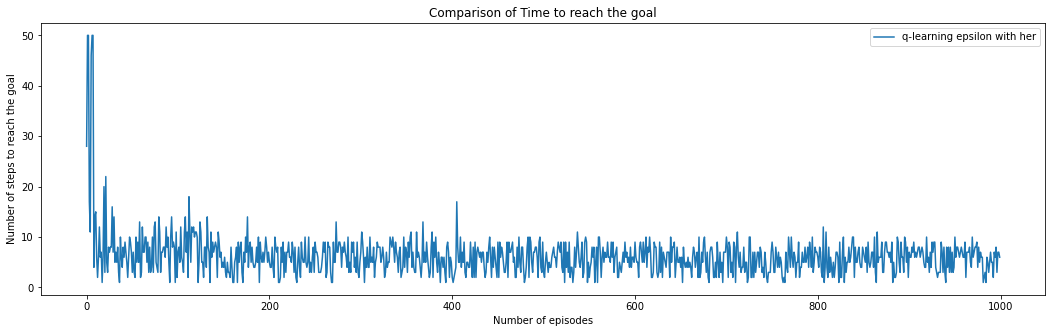

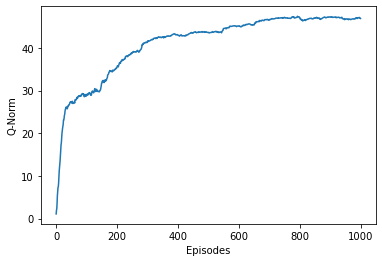

In [17]:
plot_ql_3d_goal_inorder(env, 0.01, 1000, 50,  0.5, False)